# NDWI & Pixel Classification

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/coastal-erosion-example/3_compute_NDWI.ipynb)

## Preparing Your Workspace

### Option 1: (recommended) Run in Google Colab

[Open this Notebook in Colab](https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/sdsc-2022-workshop/3_Compute_NDWI.ipynb), then run the following:

In [ ]:
!pip install rasterio
!wget https://storage.googleapis.com/pdd-stac/disasters/hurricane-harvey/0831/20170831_172754_101c_3B_AnalyticMS.tif

### Option 2: Run local Jupyter instance

You can also choose to open this Notebook in your own local Jupyter instance.

**Prerequisites**
- Install: [rasterio](https://pypi.org/project/rasterio) library
- Download example data: [20170831_172754_101c_3B_AnalyticMS.tif](https://storage.googleapis.com/pdd-stac/disasters/hurricane-harvey/0831/20170831_172754_101c_3B_AnalyticMS.tif)

## Import Packages & Load Data

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In addition to Rasterio, we'll be working with NumPy, which is a useful package for working with arrays, like our images. We will also be using Matplotlib's Pyplot module to visualize our data.

In [2]:
image_file = "/content/20170831_172754_101c_3B_AnalyticMS.tif"
satdat = rasterio.open(image_file)

## Calculate NDWI

Since we're looking at flooding in this example, it would be useful to identify areas of water v.s. areas of land.

We can measure the normalized difference water index (NDWI), which is related to plant water content and helps identify areas of water. 

NDWI can be calculated as: NDWI = (green - NIR) / (green + NIR)

You can find more information on NDWI here: https://en.wikipedia.org/wiki/Normalized_difference_water_index

First, we need to allow division by zero when we do our NDWI calculation. We do this because our image may have masked or clipped values that all have values of zero, where the sum of those values in the denominator can also be zero. We want to make sure that our code doesn't break if this happens, so we want to allow numpy to divide by zero.

In [3]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Then, we need to extract the bands we will need for our NDWI calculation. In this case, we want to extract the green and near-infrared bands.

In [4]:
with rasterio.open(image_file) as src:
    blue = src.read(1)
    green = src.read(2)
    red = src.read(3)
    nir = src.read(4)

In [5]:
# Calculate NDWI
ndwi = (green.astype(float) - nir.astype(float)) / (green.astype(float) + nir.astype(float))

We now have an array of NDWI values we can use for further analysis!

## Visualizing NDWI

We can now plot our NDWI to visualize it, similar to what we did with our original image.

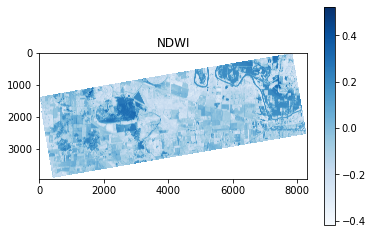

In [6]:
fig = plt.imshow(ndwi)
fig.set_cmap('Blues')
plt.title("NDWI")
plt.colorbar()
plt.show()

NDWI values range from -1 to +1. Pixels which have a relatively high NDWI value (NDWI >= 0.3) are likely to be associated with water, whereas pixels with values under this threshold (NDWI < 0.3) are unlikely to be associated with water.

Here, the darker blue areas have higher NDWI values, meaning they are more likely to be associated with water. 

Using this threshold, we can apply a filter on our NDWI array to classify pixels as being water or not water. While a threshold of 0.3 would be ideal, we will use a threshold of 0 here to account for murky waters.

In [7]:
water_mask = np.full(ndwi.shape, np.nan)
land_mask = np.full(ndwi.shape, np.nan)

water_mask[ndwi >= 0] = 1
land_mask[ndwi < 0] = 1

Now we have masks for classifying both land and water areas! We will look more at these masks in the next section.